In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

### Functions

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [2]:
starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)

### Import transport data

In [15]:
#Import  data
#Dec 13th 2017 - Dec 27th 2021
datelist_harotosouth = datelist_vs[3:]
harotosouth_df = pd.read_csv('combined2timeseries/harotosouth18-21.csv')
harotosouth = pd.DataFrame({'Transport':harotosouth_df['Transport'].values},index=datelist_harotosouth)['Transport']
harotosouth

#Import PRtovs data
#Dec 13th 2017 - Dec 27th 2021
datelist_PRtovs_haro = datelist_vs[3:]
PRtovs_haro_avg_df = pd.read_csv('combined2timeseries/PRtovs_haro_avg.csv')
PRtovs_haro_avg = pd.DataFrame({'Transport':PRtovs_haro_avg_df['Transport'].values},index=datelist_PRtovs_haro)['Transport']
PRtovs_haro_avg_df

#Import Gulftovs data
#Dec 13th 2017 - Dec 27th 2021
datelist_Gulftovs_haro = datelist_vs[3:]
Gulftovs_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs_haro_avg.csv')
Gulftovs_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro)['Transport']
Gulftovs_haro_avg

#Import ros2south data
#Dec 15th 2017 - Dec 27th 2021
datelist_rostosouth = datelist_vs[5:]
rostosouth_df = pd.read_csv('combined2timeseries/rostosouth18-21.csv')
rostosouth = pd.DataFrame({'Transport':rostosouth_df['Transport'].values},index=datelist_rostosouth)['Transport']

### Import density data

In [12]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2017-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

# density_rosVS = pd.read_csv('sigma_2018_rosariopr_202111_meanv2.csv')
# dens_diff_rosVS = np.array(density_rosVS.south - density_rosVS.north)

# density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
# dens_diff_haro = np.array(density_haro.south - density_haro.north)

density_vspr = pd.read_csv('../notebooks/sigma_2017-22_202111_mean.csv')
dens_diff_vspr = np.array(density_vspr.south - density_vspr.north)

tides = pd.read_csv('../notebooks/low_pass_tide_2018-22_BP.csv')
# tides = pd.read_csv('low_pass_tide_18-22.csv').iloc[:730,:]


date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros
print(len(datelist_dens))
print(dens_diff_ros.size)

2191
(2191,)
2191
2191


In [13]:
tides['vozocrtx']

0            NaN
1            NaN
2       0.607365
3       0.508302
4       0.436066
          ...   
2186    0.908305
2187    0.787567
2188    0.629463
2189    0.472127
2190         NaN
Name: vozocrtx, Length: 2191, dtype: float64

In [14]:
wind = pd.read_csv('../notebooks/day_avg_wind_17-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

0.8040834199174124


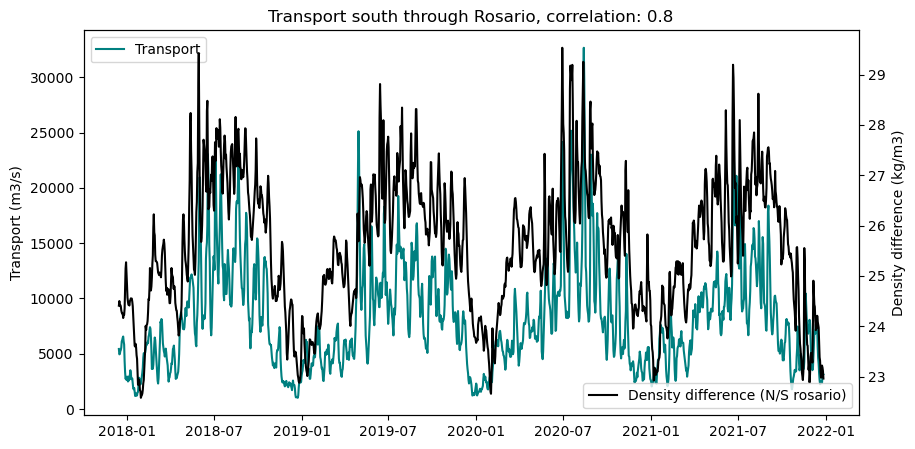

In [16]:
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())
print(corr_rostosouth)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_sh,densdiff_ros,color='k',label='Density difference (N/S rosario)')
ax.set_title(f'Transport south through Rosario, correlation: {np.round(corr_rostosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

In [17]:
slope,intercept = np.polyfit(densdiff_ros,rostosouth.dropna(),1)
ddline = slope*densdiff_ros+intercept
res = rostosouth.dropna() - ddline
print(slope,intercept)

mask = np.isin(datelist_tides,date_rossh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr_res_ros,p = stats.spearmanr(tides_sh,res)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'South through rosario, correlation = {np.round(corr_res_ros,3)}')

2677.162843369906 -60397.55886441771


Text(0.5, 1.0, 'South through rosario, correlation = -0.085')

Text(0.5, 1.0, 'corr = -0.219')

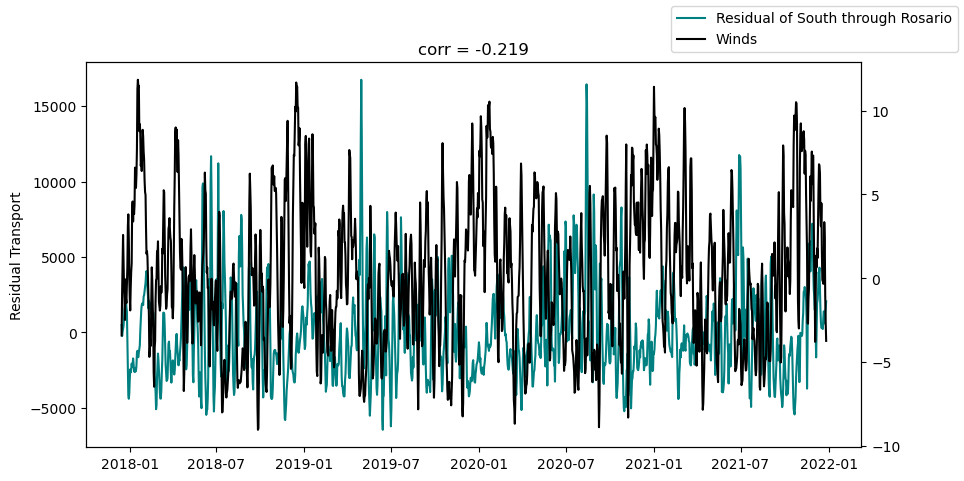

In [18]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

corr_res_ros_wind,p = stats.spearmanr(winds_sh,res)
corr_res_ros_wind

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_sh,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr_res_ros_wind,3)}')

Text(0, 0.5, 'Transport (m3/s)')

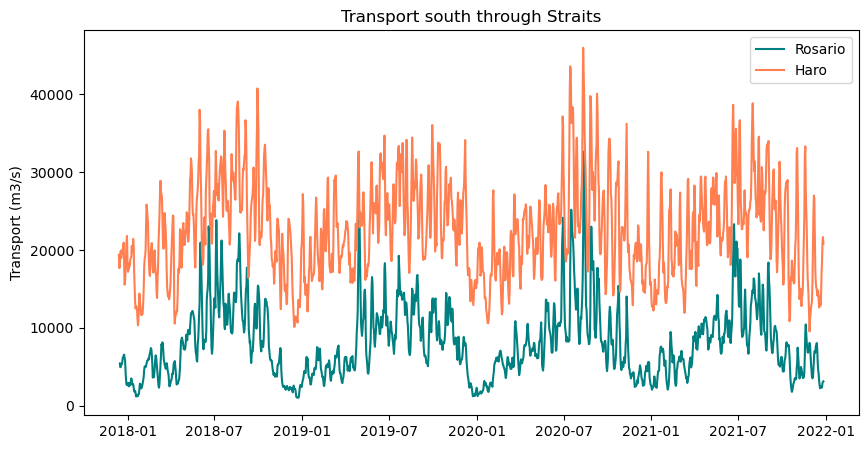

In [19]:
date_harosh = list(harotosouth.dropna().index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),label='Rosario',color='teal')
ax.plot(harotosouth.dropna(),label='Haro',color='coral')
ax.legend()
ax.set_title(f'Transport south through Straits')
ax.set_ylabel('Transport (m3/s)')

In [20]:
corr_haroros,p = stats.spearmanr(rostosouth.dropna(),harotosouth.dropna()[2:])
print(corr_haroros)

0.7126589209922758


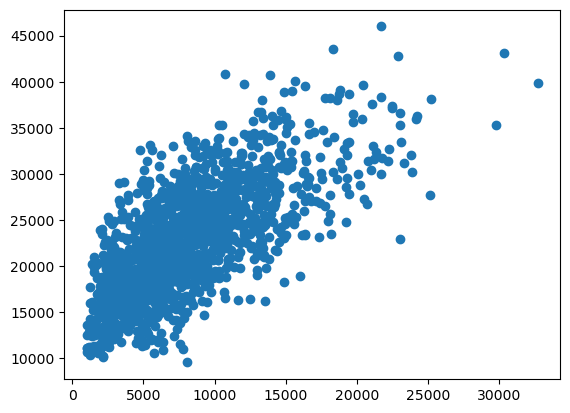

In [21]:
plt.scatter(rostosouth.dropna(),harotosouth.dropna()[2:])

#### Correlations with transport south through Haro

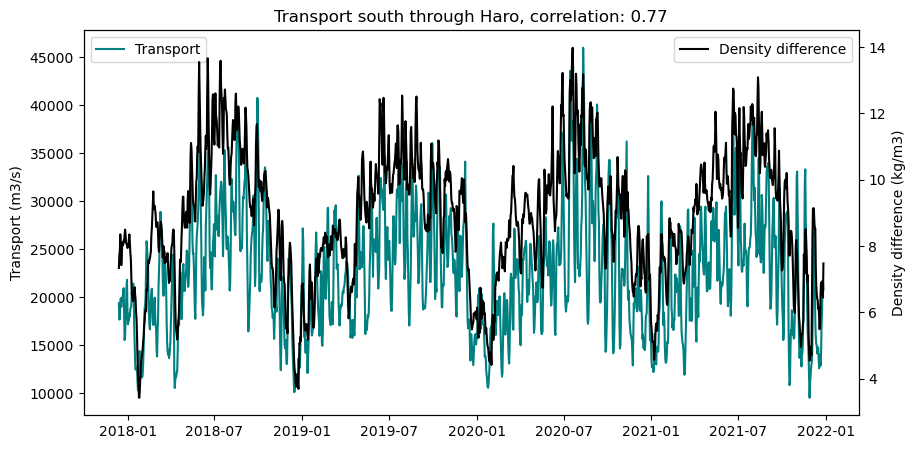

In [22]:
date_harosh = list(harotosouth.dropna().index)

mask = np.isin(datelist_dens,date_harosh)
densdiff_haro = dens_diff_vspr[mask]
date_dens_haro_sh = np.array(datelist_dens)[mask]

corr_harotosouth,p = stats.spearmanr(densdiff_haro,harotosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_haro_sh,densdiff_haro,color='k',label='Density difference')
ax.set_title(f'Transport south through Haro, correlation: {np.round(corr_harotosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

Find density difference N/S through Haro to increase this correlation?

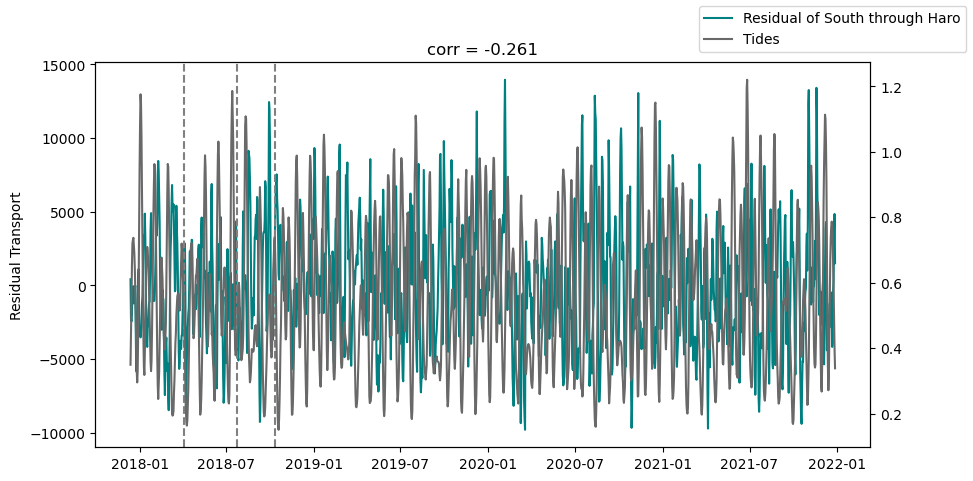

In [23]:
slope,intercept = np.polyfit(densdiff_haro,harotosouth.dropna(),1)
ddline_haro = slope*densdiff_haro+intercept
res_haro = harotosouth.dropna() - ddline_haro

mask = np.isin(datelist_tides,date_harosh)
date_tides_haro_sh = np.array(datelist_tides)[mask]
tides_haro_sh = tides.vozocrtx[mask]

corr_res_haro,p = stats.spearmanr(tides_haro_sh,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey',label='Tides')
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr_res_haro,3)}')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
# ax.plot(res,label='Residual south through Rosario',color='darkblue')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[300],ls='--',color='grey')
# ax3 = ax.twinx()
# ax3.plot(date_winds_sh,winds_sh,color='darkgrey',label='Winds')
# ax3.spines['right'].set_position(('outward', 80))
fig.legend()

In [24]:
mask = np.isin(datelist_winds,date_harosh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_haro = y_mean4[mask]

corr,p = stats.spearmanr(winds_haro,res_haro)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_haro,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Wind velocity')

Text(0, 0.5, 'Wind velocity')

In [25]:
corr,p = stats.spearmanr(winds_haro,res_haro)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='dimgrey')
ax.plot(rostosouth.dropna(),color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'Residual correlation: corr = {np.round(corr_res_ros,3)}')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')

In [26]:
slope,intercept = np.polyfit(winds_haro,harotosouth.dropna(),1)
wline_haro = slope*winds_haro+intercept
resw_haro = res_haro.values - wline_haro

mask = np.isin(datelist_tides,date_winds_sh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_winds_sh = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_winds_sh,resw_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(date_tides_sh,resw_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_winds_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Tide velocity ')

Text(0, 0.5, 'Tide velocity ')

-0.17458015042838196


Text(0.5, 1.0, 'Haro South and Tides')

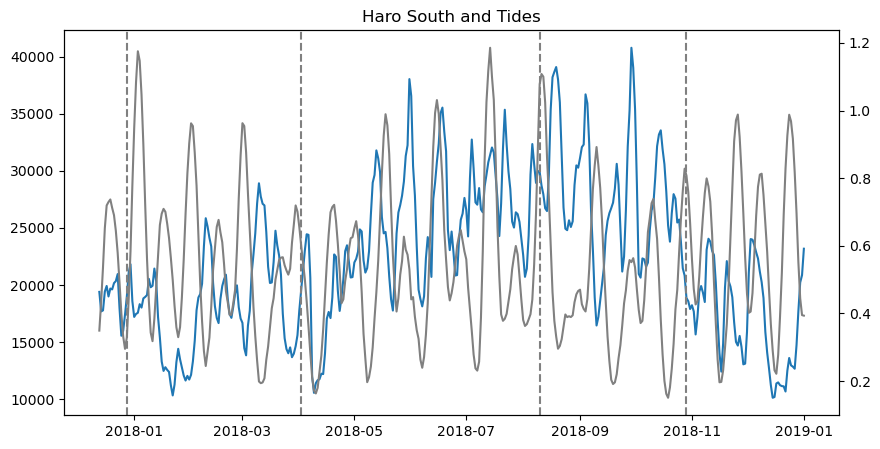

In [29]:
idx_z1 = 15
idx_z2 = 110
idx_z3 = 240
idx_z4 = 320

corr,p = stats.spearmanr(tides_haro_sh,harotosouth.dropna())
print(corr)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna()[0:385])
ax2 = ax.twinx()
ax2.plot(date_tides_sh[0:385],tides_winds_sh[0:385],color='grey')
ax.axvline(date_tides_sh[idx_z2],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z3],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z4],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z1],ls='--',color='grey')
ax.set_title('Haro South and Tides')

### Fraser River discharge

In [30]:
# Import data and take mean

FR_data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/FR_discharge.csv')
FR_4mean = FR_data['Discharge (m3/s)'].rolling(window=4,center=True).mean()

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_FR = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_FR.append(date)
    date += dt.timedelta(days=1)

### All runoff (add climatology for other rivers)

In [31]:
rivers = xr.open_dataset('/data/SalishSeaCast/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')
clim = np.zeros(365)

for river in rivers.data_vars:
    clim += rivers[river][0:]
    
clim -= rivers['fraser']

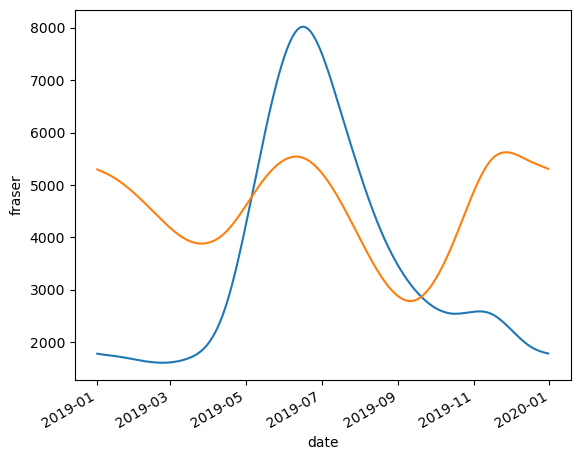

In [32]:
rivers['fraser'].plot()
clim.plot()

In [33]:
date = dt.datetime(2020,1,1)
enddate = dt.datetime(2020,12,31)
dates = []
datelist_2020 = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_2020.append(date)
    date += dt.timedelta(days=1)

idx_leap = datelist_2020.index(dt.datetime(2020,2,29))

clim2020 = np.insert(clim,idx_leap,(clim[58]+clim[59])/2)

clim1718 = np.append(clim,clim)
clim1719 = np.append(clim1718,clim)
clim1720 = np.append(clim1719,clim2020)
clim1721 = np.append(clim1720,clim)
clim1722 = np.append(clim1721,clim)
len(clim1722)

2191

In [34]:
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_yrs = []
dates = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yrs.append(date)
    date += dt.timedelta(days=1)
       
df_FR_4mean = pd.DataFrame(FR_4mean.values,index=datelist_FR)
df_clim = pd.DataFrame(clim1722,index=datelist_yrs)

runoff = df_FR_4mean.add(df_clim, fill_value=0)

In [35]:
mask = np.isin(datelist_yrs,date_harosh)
runoff_haro = runoff[0].values[mask]

corr,p = stats.spearmanr(runoff_haro,res_haro)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro,color='teal')
ax2 = ax.twinx()
ax2.plot(date_harosh,tides_haro_sh,color='coral')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_harosh,runoff_haro,color='purple')
ax.axvline(date_harosh[110],color='dimgrey',ls='--')
ax.axvline(date_harosh[240],color='dimgrey',ls='--')
ax.set_title('Haro')

-0.04348775015395007


Text(0.5, 1.0, 'Haro')

In [36]:
mask = np.isin(datelist_yrs,date_harosh)
FR_haro = FR_4mean[mask]

corr_2018,p = stats.spearmanr(tides_haro_sh[110:240],res_haro[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_haro_sh[470:600],res_haro[470:600])
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_haro_sh[860:970],res_haro[860:970])
print(corr_2020)
corr_2021,p = stats.spearmanr(tides_haro_sh[1210:1330],res_haro[1210:1330])
print(corr_2021)

fig,[ax,ax4,ax5,ax6] = plt.subplots(4,1,figsize=(10,10))

ax.plot(res_haro[0:379],color='teal',label='residual haro')
ax2 = ax.twinx()
ax2.plot(date_harosh[0:379],tides_haro_sh[0:379],color='coral',label='tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_harosh[0:379],FR_haro[0:379],color='purple',label='river flow')
ax.set_title(f'Correlation: {np.round(corr_2018,2)}')
ax.set_ylim([-11000,12000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_harosh[110],x2=date_harosh[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow')
fig.legend()
fig.suptitle('Haro south flow')


ax4.plot(res_haro[379:750],color='teal')
ax42 = ax4.twinx()
ax42.plot(date_harosh[379:750],tides_haro_sh[379:750],color='coral')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_harosh[379:750],FR_haro[379:750],color='purple')
ax4.set_title(f'Correlation: {np.round(corr_2019,2)}')
ax4.set_ylim([-11000,12000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_harosh[470],x2=date_harosh[600],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')
ax43.set_ylabel('Fraser river flow')

ax5.plot(res_haro[750:1100],color='teal')
ax52 = ax5.twinx()
ax52.plot(date_harosh[750:1100],tides_haro_sh[750:1100],color='coral')
ax53 = ax5.twinx()
# ax3.plot(haro_btrop,color='coral')
ax53.plot(date_harosh[750:1100],FR_haro[750:1100],color='purple')
ax5.set_title(f'Correlation: {np.round(corr_2020,2)}')
ax5.set_ylim([-11000,12000])
ax5.fill_betweenx(y=np.linspace(ax5.get_ylim()[0], ax5.get_ylim()[1], 100),x1=date_harosh[860],x2=date_harosh[970],color='lightgrey', alpha=0.3)
ax53.spines['right'].set_position(('outward', 60))
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')
ax53.set_ylabel('Fraser river flow')

ax6.plot(res_haro[1100:],color='teal')
ax62 = ax6.twinx()
ax62.plot(date_harosh[1100:],tides_haro_sh[1100:],color='coral')
ax63 = ax6.twinx()
# ax3.plot(haro_btrop,color='coral')
ax63.plot(date_harosh[1100:],FR_haro[1100:],color='purple')
ax6.set_title(f'Correlation: {np.round(corr_2021,2)}')
ax6.set_ylim([-11000,12000])
ax6.fill_betweenx(y=np.linspace(ax6.get_ylim()[0], ax6.get_ylim()[1], 100),x1=date_harosh[1210],x2=date_harosh[1330],color='lightgrey', alpha=0.3)
ax63.spines['right'].set_position(('outward', 60))
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Tide velocity')
ax63.set_ylabel('Fraser river flow')

plt.subplots_adjust(hspace=0.4)

0.20431523030493384
-0.36421363121167843
-0.47577034916484456
-0.42136259462462666


In [37]:
#Compare correlation with density difference b/w years

corr,p = stats.spearmanr(densdiff_haro[110:240],harotosouth.dropna()[110:240])
print(corr)
corr,p = stats.spearmanr(densdiff_haro[470:600],harotosouth.dropna()[470:600])
print(corr)
corr,p = stats.spearmanr(densdiff_haro[860:970],harotosouth.dropna()[860:970])
print(corr)
corr,p = stats.spearmanr(densdiff_haro[1210:1330],harotosouth.dropna()[1210:1330])
print(corr)

0.8307501126602848
0.758401726092122
0.7221648671189955
0.6715049656226126


The positive correlation doesn't happen in 2019 or 2020

In [38]:
corr,p = stats.spearmanr(tides_haro_sh[110:240],res_haro[110:240])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[470:600],res_haro[470:600])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[860:970],res_haro[860:970])
print(corr)

corr,p = stats.spearmanr(tides_haro_sh[:379],res_haro[:379])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[379:750],res_haro[379:750])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[750:],res_haro[750:])
print(corr)

0.20431523030493384
-0.36421363121167843
-0.47577034916484456
-0.16982716245318663
-0.2656946399490527
-0.31007215480099704


Rosario

-0.057488153600349576
-0.24475822420079474
-0.17134549061154564
-0.18715188554760742


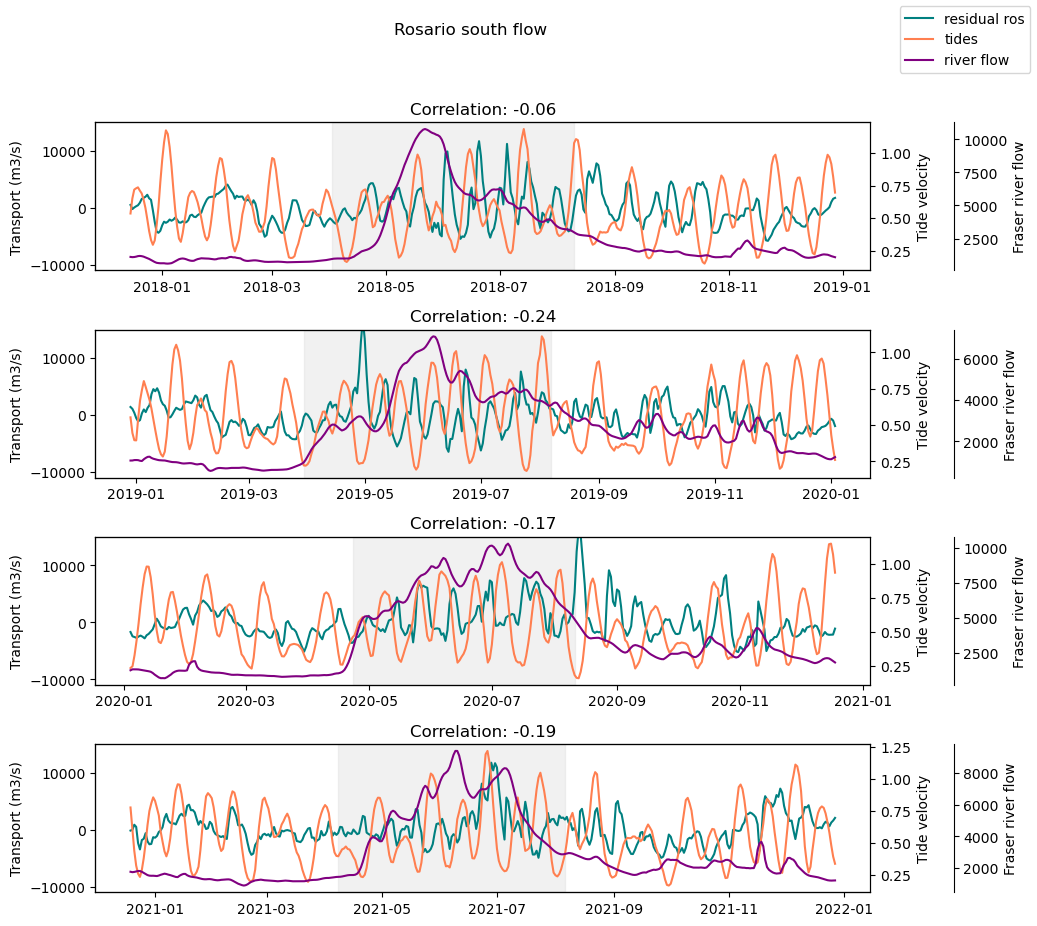

In [39]:
mask = np.isin(datelist_yrs,date_harosh)
FR_haro = FR_4mean[mask]

corr_2018,p = stats.spearmanr(tides_sh[110:240],res[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_sh[470:600],res[470:600])
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_sh[860:970],res[860:970])
print(corr_2020)
corr_2021,p = stats.spearmanr(tides_sh[1210:1330],res[1210:1330])
print(corr_2021)


fig,[ax,ax4,ax5,ax6] = plt.subplots(4,1,figsize=(10,10))

ax.plot(res[0:379],color='teal',label='residual ros')
ax2 = ax.twinx()
ax2.plot(date_rossh[0:379],tides_sh[0:379],color='coral',label='tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_rossh[0:379],FR_haro[0:379],color='purple',label='river flow')
ax.set_title(f'Correlation: {np.round(corr_2018,2)}')
ax.set_ylim([-11000,15000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_harosh[110],x2=date_harosh[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow')
fig.legend()
fig.suptitle('Rosario south flow')

ax4.plot(res[379:750],color='teal')
ax42 = ax4.twinx()
ax42.plot(date_rossh[379:750],tides_sh[379:750],color='coral')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_rossh[379:750],FR_haro[379:750],color='purple')
ax4.set_title(f'Correlation: {np.round(corr_2019,2)}')
ax4.set_ylim([-11000,15000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_rossh[470],x2=date_rossh[600],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')
ax43.set_ylabel('Fraser river flow')

ax5.plot(res[750:1100],color='teal')
ax52 = ax5.twinx()
ax52.plot(date_rossh[750:1100],tides_sh[750:1100],color='coral')
ax53 = ax5.twinx()
# ax3.plot(haro_btrop,color='coral')
ax53.plot(date_rossh[750:1100],FR_haro[750:1100],color='purple')
ax5.set_title(f'Correlation: {np.round(corr_2020,2)}')
ax5.set_ylim([-11000,15000])
ax5.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_rossh[860],x2=date_rossh[970],color='lightgrey', alpha=0.3)
ax53.spines['right'].set_position(('outward', 60))
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')
ax53.set_ylabel('Fraser river flow')

ax6.plot(res[1100:],color='teal')
ax62 = ax6.twinx()
ax62.plot(date_rossh[1100:],tides_sh[1100:],color='coral')
ax63 = ax6.twinx()
# ax3.plot(haro_btrop,color='coral')
ax63.plot(date_rossh[1100:],FR_haro[1100:-2],color='purple')
ax6.set_title(f'Correlation: {np.round(corr_2021,2)}')
ax6.set_ylim([-11000,15000])
ax6.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_rossh[1210],x2=date_rossh[1330],color='lightgrey', alpha=0.3)
ax63.spines['right'].set_position(('outward', 60))
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Tide velocity')
ax63.set_ylabel('Fraser river flow')

plt.subplots_adjust(hspace=0.4)

#### Look with SSH

In [41]:
ssh_jdf_data = pd.read_csv('../notebooks/ssh_jdf_4day_mean_17-22.csv')
ssh_jdf = ssh_jdf_data['SSH']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_ssh = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_ssh.append(date)
    date+=dt.timedelta(days=1)

mask = np.isin(datelist_ssh,date_harosh)
ssh_jdf_sh = ssh_jdf[mask]

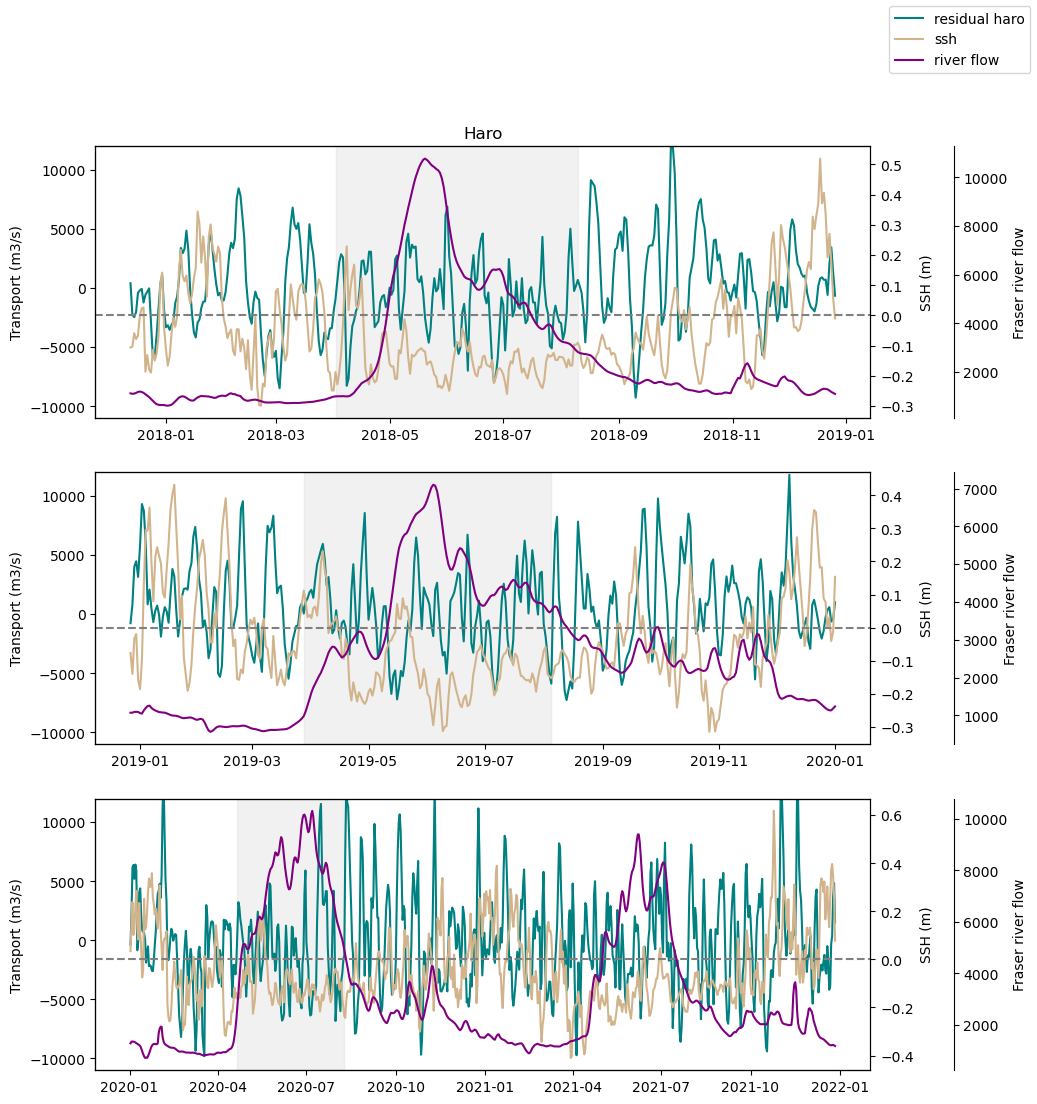

In [42]:
fig,[ax,ax4,ax5] = plt.subplots(3,1,figsize=(10,12))

ax.plot(res_haro[0:379],color='teal',label='residual haro')
ax2 = ax.twinx()
ax2.plot(date_harosh[0:379],ssh_jdf_sh[0:379],color='tan',label='ssh')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_harosh[0:379],FR_haro[0:379],color='purple',label='river flow')
ax.set_title('Haro')
ax.set_ylim([-11000,12000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_harosh[110],x2=date_harosh[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('SSH (m)')
ax3.set_ylabel('Fraser river flow')
fig.legend()

ax4.plot(res_haro[379:750],color='teal')
ax42 = ax4.twinx()
ax42.plot(date_harosh[379:750],ssh_jdf_sh[379:750],color='tan')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_harosh[379:750],FR_haro[379:750],color='purple')
# ax4.set_title('Haro')
ax4.set_ylim([-11000,12000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_harosh[470],x2=date_harosh[600],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('SSH (m)')
ax43.set_ylabel('Fraser river flow')

ax5.plot(res_haro[750:],color='teal')
ax52 = ax5.twinx()
ax52.plot(date_harosh[750:len(ssh_jdf_sh)],ssh_jdf_sh[750:],color='tan')
ax53 = ax5.twinx()
# ax3.plot(haro_btrop,color='coral')
ax53.plot(date_harosh[750:],FR_haro[750:],color='purple')
# ax5.set_title('Haro')
ax5.set_ylim([-11000,12000])
ax5.fill_betweenx(y=np.linspace(ax5.get_ylim()[0], ax5.get_ylim()[1], 100),x1=date_harosh[860],x2=date_harosh[970],color='lightgrey', alpha=0.3)
ax53.spines['right'].set_position(('outward', 60))
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('SSH (m)')
ax53.set_ylabel('Fraser river flow')

ax2.axhline(y=0,color='grey',ls='--')
ax42.axhline(y=0,color='grey',ls='--')
ax52.axhline(y=0,color='grey',ls='--')

In [43]:
corr,p = stats.spearmanr(res_haro[110:240],ssh_jdf_sh[110:240])
print(corr)
corr,p = stats.spearmanr(res_haro[480:600],ssh_jdf_sh[480:600])
print(corr)

-0.1960398202897759
-0.19852073060629208


### Look at correlations of South Haro with winds, tides, FR flow

First need to calculate tides, residual separately for each year ..

In [44]:
#South flow through Haro
harotosouth_2018 = harotosouth.dropna()[0:384]
harotosouth_2019 = harotosouth.dropna()[384:749]
harotosouth_2020 = harotosouth.dropna()[749:1110]
harotosouth_2021 = harotosouth.dropna()[1110:]

#Tides
tides_haro_2018 = tides_haro_sh[0:384]
tides_haro_2019 = tides_haro_sh[384:749]
tides_haro_2020 = tides_haro_sh[749:1110]
tides_haro_2021 = tides_haro_sh[1110:]

#Winds
winds_haro_2018 = winds_haro[0:384]
winds_haro_2019 = winds_haro[384:749]
winds_haro_2020 = winds_haro[749:1110]
winds_haro_2021 = winds_haro[1110:]

#Density difference
densdiff_haro_2018 = densdiff_haro[0:384]
densdiff_haro_2019 = densdiff_haro[384:749]
densdiff_haro_2020 = densdiff_haro[749:1110]
densdiff_haro_2021 = densdiff_haro[1110:]

#residual 2018
slope,intercept = np.polyfit(densdiff_haro_2018,harotosouth_2018,1)
ddline_haro_2018 = slope*densdiff_haro_2018+intercept
res_haro_2018 = harotosouth_2018 - ddline_haro_2018

#residual 2019
slope,intercept = np.polyfit(densdiff_haro_2019,harotosouth_2019,1)
ddline_haro_2019 = slope*densdiff_haro_2019+intercept
res_haro_2019 = harotosouth_2019 - ddline_haro_2019

#residual 2020
slope,intercept = np.polyfit(densdiff_haro_2020,harotosouth_2020,1)
ddline_haro_2020 = slope*densdiff_haro_2020+intercept
res_haro_2020 = harotosouth_2020 - ddline_haro_2020

#residual 2021
slope,intercept = np.polyfit(densdiff_haro_2021,harotosouth_2021,1)
ddline_haro_2021 = slope*densdiff_haro_2021+intercept
res_haro_2021 = harotosouth_2021 - ddline_haro_2021

#date
date_haro_2018 = date_harosh[0:384]
date_haro_2019 = date_harosh[384:749]
date_haro_2020 = date_harosh[749:1110]
date_haro_2021 = date_harosh[1110:]

Look at residual with tides

0.20832457086673314
-0.36149220441276164
-0.4960530056198203
-0.42432048282346774


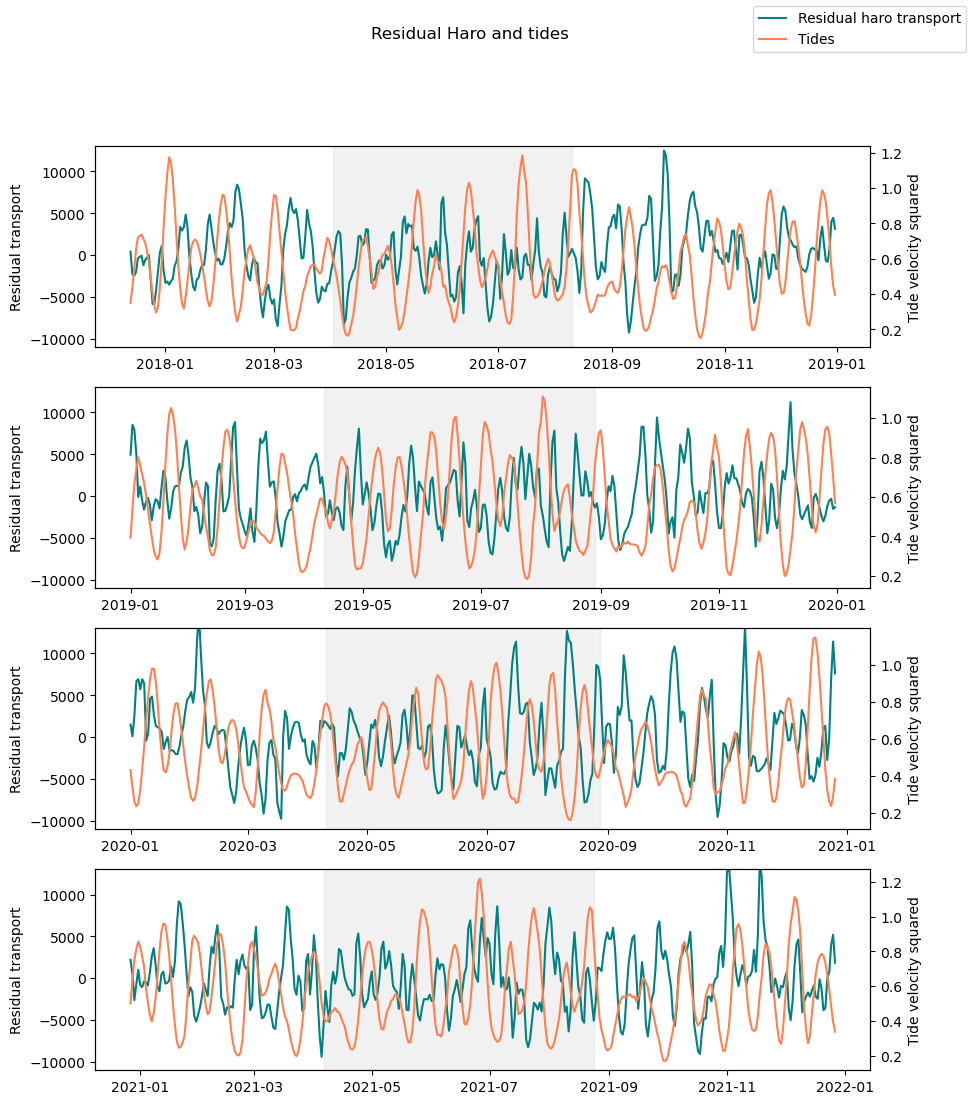

In [45]:
corr_2018,p = stats.spearmanr(tides_haro_2018[110:240],res_haro_2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_haro_2019[100:240],res_haro_2019[100:240])
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_haro_2020[100:240],res_haro_2020[100:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(tides_haro_2021[100:240],res_haro_2021[100:240])
print(corr_2021)

fig,[ax,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(10,12))
ax.plot(res_haro_2018,color='teal',label='Residual haro transport')
ax12 = ax.twinx()
ax12.plot(date_haro_2018,tides_haro_2018,color='coral',label='Tides')
ax.set_ylim((-11000,13000))
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_2018[110],x2=date_haro_2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Residual transport')
ax12.set_ylabel('Tide velocity squared')

ax2.plot(res_haro_2019,color='teal')
ax22 = ax2.twinx()
ax22.plot(date_haro_2019,tides_haro_2019,color='coral')
ax2.set_ylim((-11000,13000))
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=date_haro_2019[100],x2=date_haro_2019[240],color='lightgrey', alpha=0.3)
ax2.set_ylabel('Residual transport')
ax22.set_ylabel('Tide velocity squared')

ax3.plot(res_haro_2020,color='teal')
ax32 = ax3.twinx()
ax32.plot(date_haro_2020,tides_haro_2020,color='coral')
ax3.set_ylim((-11000,13000))
ax3.fill_betweenx(y=np.linspace(ax3.get_ylim()[0], ax3.get_ylim()[1], 100),x1=date_haro_2020[100],x2=date_haro_2020[240],color='lightgrey', alpha=0.3)
ax3.set_ylabel('Residual transport')
ax32.set_ylabel('Tide velocity squared')

ax4.plot(res_haro_2021,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_haro_2021,tides_haro_2021,color='coral')
ax4.set_ylim((-11000,13000))
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_haro_2021[100],x2=date_haro_2021[240],color='lightgrey', alpha=0.3)
ax4.set_ylabel('Residual transport')
ax42.set_ylabel('Tide velocity squared')

fig.suptitle('Residual Haro and tides')
fig.legend()

Look at correlations with the wind

0.022086878149367054
-0.20275086921344387
-0.30380704554897126
-0.211388336139599


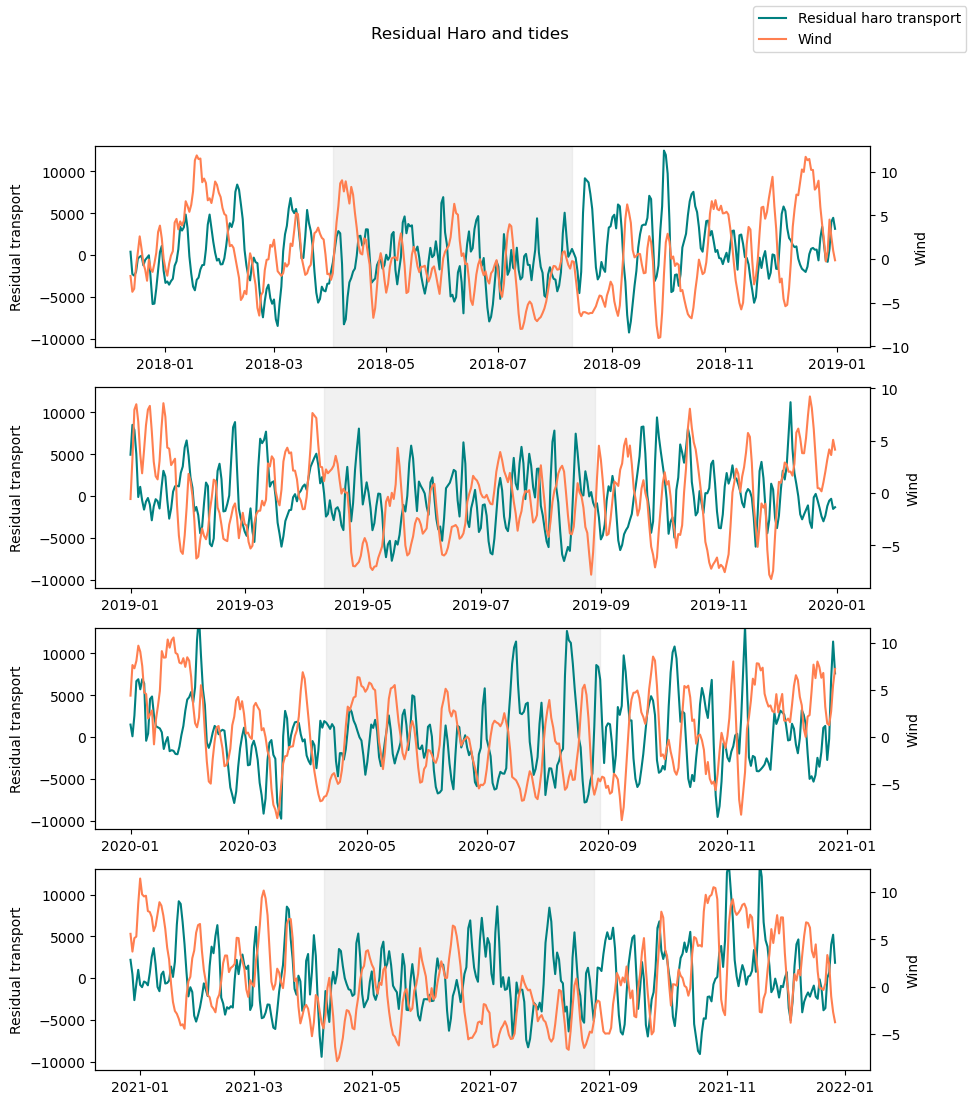

In [46]:
corr_2018,p = stats.spearmanr(winds_haro_2018[110:240],res_haro_2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(winds_haro_2019[100:240],res_haro_2019[100:240])
print(corr_2019)
corr_2020,p = stats.spearmanr(winds_haro_2020[100:240],res_haro_2020[100:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(winds_haro_2021[100:240],res_haro_2021[100:240])
print(corr_2021)

fig,[ax,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(10,12))
ax.plot(res_haro_2018,color='teal',label='Residual haro transport')
ax12 = ax.twinx()
ax12.plot(date_haro_2018,winds_haro_2018,color='coral',label='Wind')
ax.set_ylim((-11000,13000))
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_2018[110],x2=date_haro_2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Residual transport')
ax12.set_ylabel('Wind')

ax2.plot(res_haro_2019,color='teal')
ax22 = ax2.twinx()
ax22.plot(date_haro_2019,winds_haro_2019,color='coral')
ax2.set_ylim((-11000,13000))
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=date_haro_2019[100],x2=date_haro_2019[240],color='lightgrey', alpha=0.3)
ax2.set_ylabel('Residual transport')
ax22.set_ylabel('Wind')

ax3.plot(res_haro_2020,color='teal')
ax32 = ax3.twinx()
ax32.plot(date_haro_2020,winds_haro_2020,color='coral')
ax3.set_ylim((-11000,13000))
ax3.fill_betweenx(y=np.linspace(ax3.get_ylim()[0], ax3.get_ylim()[1], 100),x1=date_haro_2020[100],x2=date_haro_2020[240],color='lightgrey', alpha=0.3)
ax3.set_ylabel('Residual transport')
ax32.set_ylabel('Wind')

ax4.plot(res_haro_2021,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_haro_2021,winds_haro_2021,color='coral')
ax4.set_ylim((-11000,13000))
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_haro_2021[100],x2=date_haro_2021[240],color='lightgrey', alpha=0.3)
ax4.set_ylabel('Residual transport')
ax42.set_ylabel('Wind')

fig.suptitle('Residual Haro and tides')
fig.legend()

Pretty much no correlation with the wind and positive correlation with the tides in 2018

Split into PRtovs and Gulftovs

In [47]:
PRtovs_haro_2018 = PRtovs_haro_avg.dropna()[0:384]
PRtovs_haro_2019 = PRtovs_haro_avg.dropna()[384:749]
PRtovs_haro_2020 = PRtovs_haro_avg.dropna()[749:1110]
PRtovs_haro_2021 = PRtovs_haro_avg.dropna()[1110:]

#Date
date_prtovs_haro = list(PRtovs_haro_avg.dropna().index)
date_prtovs_2018 = date_prtovs_haro[0:384]
date_prtovs_2019 = date_prtovs_haro[384:749]
date_prtovs_2020 = date_prtovs_haro[749:1110]
date_prtovs_2021 = date_prtovs_haro[1110:]

#Tides
mask = np.isin(datelist_tides,date_prtovs_haro)
tides_prtovs_haro = tides.vozocrtx[mask]
tides_prtovs_2018 = tides_prtovs_haro[0:384]
tides_prtovs_2019 = tides_prtovs_haro[384:749]
tides_prtovs_2020 = tides_prtovs_haro[749:1110]
tides_prtovs_2021 = tides_prtovs_haro[1110:]

#Winds
mask = np.isin(datelist_winds,date_prtovs_haro)
winds_prtovs_haro = y_mean4[mask]
winds_prtovs_2018 = winds_prtovs_haro[0:384]
winds_prtovs_2019 = winds_prtovs_haro[384:749]
winds_prtovs_2020 = winds_prtovs_haro[749:1110]
winds_prtovs_2021 = winds_prtovs_haro[1110:]

#Density difference
mask = np.isin(datelist_dens,date_prtovs_haro)
densdiff_prtovs_haro = dens_diff_vspr[mask]
densdiff_prtovs_2018 = densdiff_prtovs_haro[0:384]
densdiff_prtovs_2019 = densdiff_prtovs_haro[384:749]
densdiff_prtovs_2020 = densdiff_prtovs_haro[749:1110]
densdiff_prtovs_2021 = densdiff_prtovs_haro[1110:]

#residual 2018
slope,intercept = np.polyfit(densdiff_prtovs_2018,PRtovs_haro_2018,1)
ddline_prtovs_2018 = slope*densdiff_prtovs_2018+intercept
res_prtovs_2018 = PRtovs_haro_2018 - ddline_prtovs_2018

#residual 2019
slope,intercept = np.polyfit(densdiff_prtovs_2019,PRtovs_haro_2019,1)
ddline_prtovs_2019 = slope*densdiff_prtovs_2019+intercept
res_prtovs_2019 = PRtovs_haro_2019 - ddline_prtovs_2019

#residual 2020
slope,intercept = np.polyfit(densdiff_prtovs_2020,PRtovs_haro_2020,1)
ddline_prtovs_2020 = slope*densdiff_prtovs_2020+intercept
res_prtovs_2020 = PRtovs_haro_2020 - ddline_prtovs_2020

#residual 2021
slope,intercept = np.polyfit(densdiff_prtovs_2021,PRtovs_haro_2021,1)
ddline_prtovs_2021 = slope*densdiff_prtovs_2021+intercept
res_prtovs_2021 = PRtovs_haro_2021 - ddline_prtovs_2021


0.27459339879009687
-0.2824648487896613
-0.4424219894601037
-0.4009621482145591


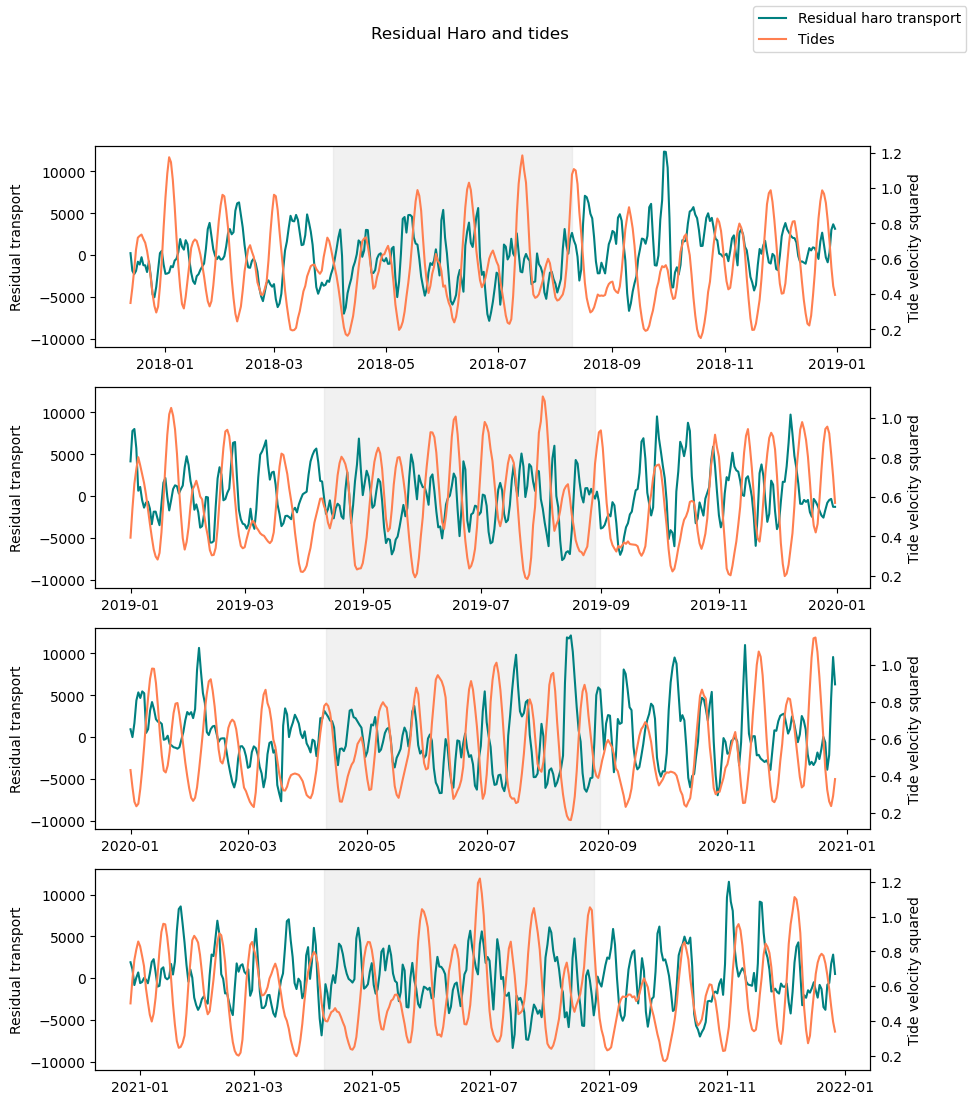

In [48]:
corr_2018,p = stats.spearmanr(tides_prtovs_2018[110:240],res_prtovs_2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_prtovs_2019[100:240],res_prtovs_2019[100:240])
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_prtovs_2020[100:240],res_prtovs_2020[100:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(tides_prtovs_2021[100:240],res_prtovs_2021[100:240])
print(corr_2021)

fig,[ax,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(10,12))
ax.plot(res_prtovs_2018,color='teal',label='Residual haro transport')
ax12 = ax.twinx()
ax12.plot(date_prtovs_2018,tides_prtovs_2018,color='coral',label='Tides')
ax.set_ylim((-11000,13000))
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs_2018[110],x2=date_prtovs_2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Residual transport')
ax12.set_ylabel('Tide velocity squared')

ax2.plot(res_prtovs_2019,color='teal')
ax22 = ax2.twinx()
ax22.plot(date_prtovs_2019,tides_prtovs_2019,color='coral')
ax2.set_ylim((-11000,13000))
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=date_prtovs_2019[100],x2=date_prtovs_2019[240],color='lightgrey', alpha=0.3)
ax2.set_ylabel('Residual transport')
ax22.set_ylabel('Tide velocity squared')

ax3.plot(res_prtovs_2020,color='teal')
ax32 = ax3.twinx()
ax32.plot(date_prtovs_2020,tides_prtovs_2020,color='coral')
ax3.set_ylim((-11000,13000))
ax3.fill_betweenx(y=np.linspace(ax3.get_ylim()[0], ax3.get_ylim()[1], 100),x1=date_prtovs_2020[100],x2=date_prtovs_2020[240],color='lightgrey', alpha=0.3)
ax3.set_ylabel('Residual transport')
ax32.set_ylabel('Tide velocity squared')

ax4.plot(res_prtovs_2021,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtovs_2021,tides_prtovs_2021,color='coral')
ax4.set_ylim((-11000,13000))
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_prtovs_2021[100],x2=date_prtovs_2021[240],color='lightgrey', alpha=0.3)
ax4.set_ylabel('Residual transport')
ax42.set_ylabel('Tide velocity squared')

fig.suptitle('Residual Haro and tides')
fig.legend()

### Gulf to VS

In [49]:
Gulftovs_haro_2018 = Gulftovs_haro_avg.dropna()[0:384]
Gulftovs_haro_2019 = Gulftovs_haro_avg.dropna()[384:749]
Gulftovs_haro_2020 = Gulftovs_haro_avg.dropna()[749:1110]
Gulftovs_haro_2021 = Gulftovs_haro_avg.dropna()[1110:]

#Date
date_Gulftovs_haro = list(Gulftovs_haro_avg.dropna().index)
date_Gulftovs_2018 = date_Gulftovs_haro[0:384]
date_Gulftovs_2019 = date_Gulftovs_haro[384:749]
date_Gulftovs_2020 = date_Gulftovs_haro[749:1110]
date_Gulftovs_2021 = date_Gulftovs_haro[1110:]

#Tides
mask = np.isin(datelist_tides,date_Gulftovs_haro)
tides_Gulftovs_haro = tides.vozocrtx[mask]
tides_Gulftovs_2018 = tides_Gulftovs_haro[0:384]
tides_Gulftovs_2019 = tides_Gulftovs_haro[384:749]
tides_Gulftovs_2020 = tides_Gulftovs_haro[749:1110]
tides_Gulftovs_2021 = tides_Gulftovs_haro[1110:]

#Winds
mask = np.isin(datelist_winds,date_Gulftovs_haro)
winds_gulftovs_haro = y_mean4[mask]
winds_gulftovs_2018 = winds_gulftovs_haro[0:384]
winds_gulftovs_2019 = winds_gulftovs_haro[384:749]
winds_gulftovs_2020 = winds_gulftovs_haro[749:1110]
winds_gulftovs_2021 = winds_gulftovs_haro[1110:]

#Density difference
mask = np.isin(datelist_dens,date_Gulftovs_haro)
densdiff_Gulftovs_haro = dens_diff_vspr[mask]
densdiff_Gulftovs_2018 = densdiff_Gulftovs_haro[0:384]
densdiff_Gulftovs_2019 = densdiff_Gulftovs_haro[384:749]
densdiff_Gulftovs_2020 = densdiff_Gulftovs_haro[749:1110]
densdiff_Gulftovs_2021 = densdiff_Gulftovs_haro[1110:]

#residual 2018
slope,intercept = np.polyfit(densdiff_Gulftovs_2018,Gulftovs_haro_2018,1)
ddline_Gulftovs_2018 = slope*densdiff_Gulftovs_2018+intercept
res_Gulftovs_2018 = Gulftovs_haro_2018 - ddline_Gulftovs_2018

#residual 2019
slope,intercept = np.polyfit(densdiff_Gulftovs_2019,Gulftovs_haro_2019,1)
ddline_Gulftovs_2019 = slope*densdiff_Gulftovs_2019+intercept
res_Gulftovs_2019 = Gulftovs_haro_2019 - ddline_Gulftovs_2019

#residual 2020
slope,intercept = np.polyfit(densdiff_Gulftovs_2020,Gulftovs_haro_2020,1)
ddline_Gulftovs_2020 = slope*densdiff_Gulftovs_2020+intercept
res_Gulftovs_2020 = Gulftovs_haro_2020 - ddline_Gulftovs_2020

#residual 2021
slope,intercept = np.polyfit(densdiff_Gulftovs_2021,Gulftovs_haro_2021,1)
ddline_Gulftovs_2021 = slope*densdiff_Gulftovs_2021+intercept
res_Gulftovs_2021 = Gulftovs_haro_2021 - ddline_Gulftovs_2021


-0.19720875609389718
-0.4106536047757539
-0.25166298572084583
-0.1343202641534189


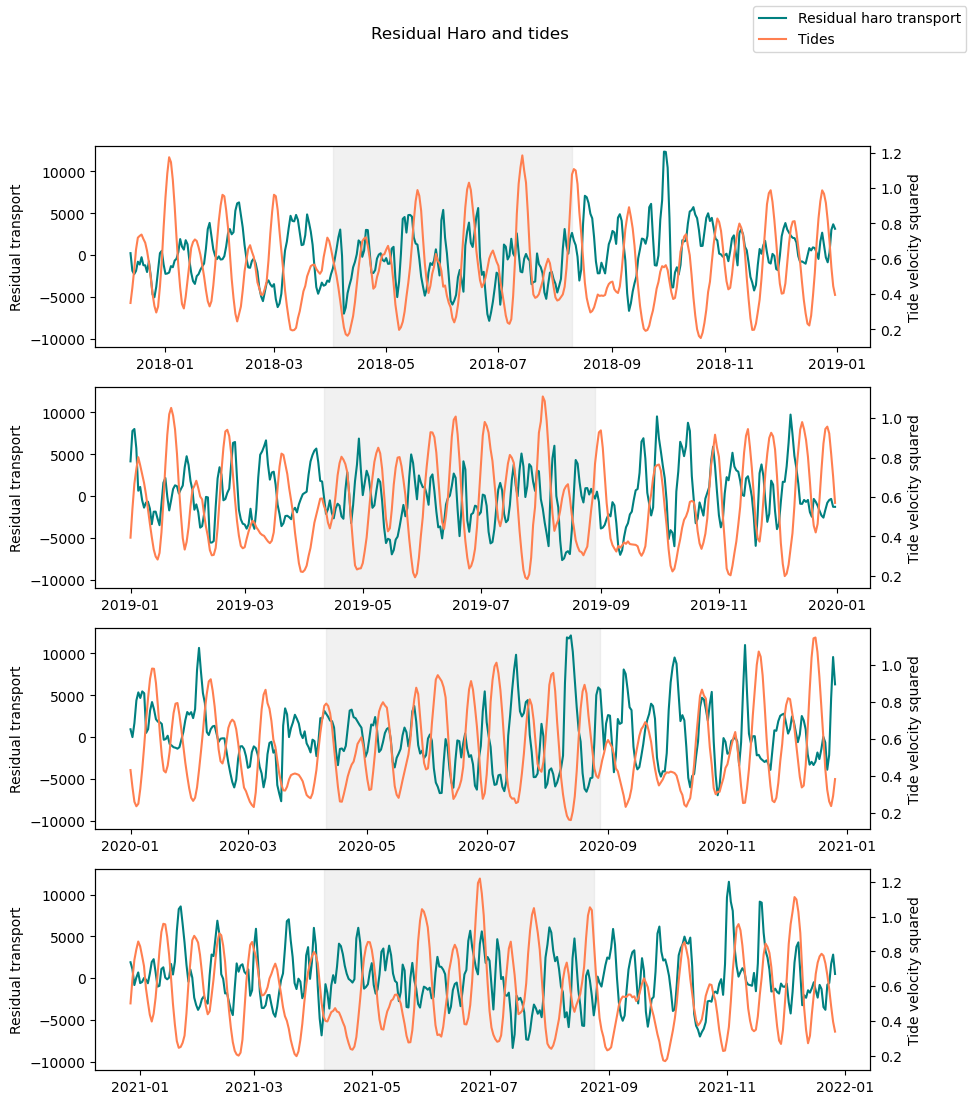

In [50]:
corr_2018,p = stats.spearmanr(tides_Gulftovs_2018[110:240],res_Gulftovs_2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(tides_Gulftovs_2019[100:240],res_Gulftovs_2019[100:240])
print(corr_2019)
corr_2020,p = stats.spearmanr(tides_Gulftovs_2020[100:240],res_Gulftovs_2020[100:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(tides_Gulftovs_2021[100:240],res_Gulftovs_2021[100:240])
print(corr_2021)

fig,[ax,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(10,12))
ax.plot(res_prtovs_2018,color='teal',label='Residual haro transport')
ax12 = ax.twinx()
ax12.plot(date_prtovs_2018,tides_prtovs_2018,color='coral',label='Tides')
ax.set_ylim((-11000,13000))
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs_2018[110],x2=date_prtovs_2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Residual transport')
ax12.set_ylabel('Tide velocity squared')

ax2.plot(res_prtovs_2019,color='teal')
ax22 = ax2.twinx()
ax22.plot(date_prtovs_2019,tides_prtovs_2019,color='coral')
ax2.set_ylim((-11000,13000))
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=date_prtovs_2019[100],x2=date_prtovs_2019[240],color='lightgrey', alpha=0.3)
ax2.set_ylabel('Residual transport')
ax22.set_ylabel('Tide velocity squared')

ax3.plot(res_prtovs_2020,color='teal')
ax32 = ax3.twinx()
ax32.plot(date_prtovs_2020,tides_prtovs_2020,color='coral')
ax3.set_ylim((-11000,13000))
ax3.fill_betweenx(y=np.linspace(ax3.get_ylim()[0], ax3.get_ylim()[1], 100),x1=date_prtovs_2020[100],x2=date_prtovs_2020[240],color='lightgrey', alpha=0.3)
ax3.set_ylabel('Residual transport')
ax32.set_ylabel('Tide velocity squared')

ax4.plot(res_prtovs_2021,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtovs_2021,tides_prtovs_2021,color='coral')
ax4.set_ylim((-11000,13000))
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_prtovs_2021[100],x2=date_prtovs_2021[240],color='lightgrey', alpha=0.3)
ax4.set_ylabel('Residual transport')
ax42.set_ylabel('Tide velocity squared')

fig.suptitle('Residual Haro and tides')
fig.legend()

-0.07199060481503229
-0.04622684830858718
-0.1423454549430365
-0.3017602938925456


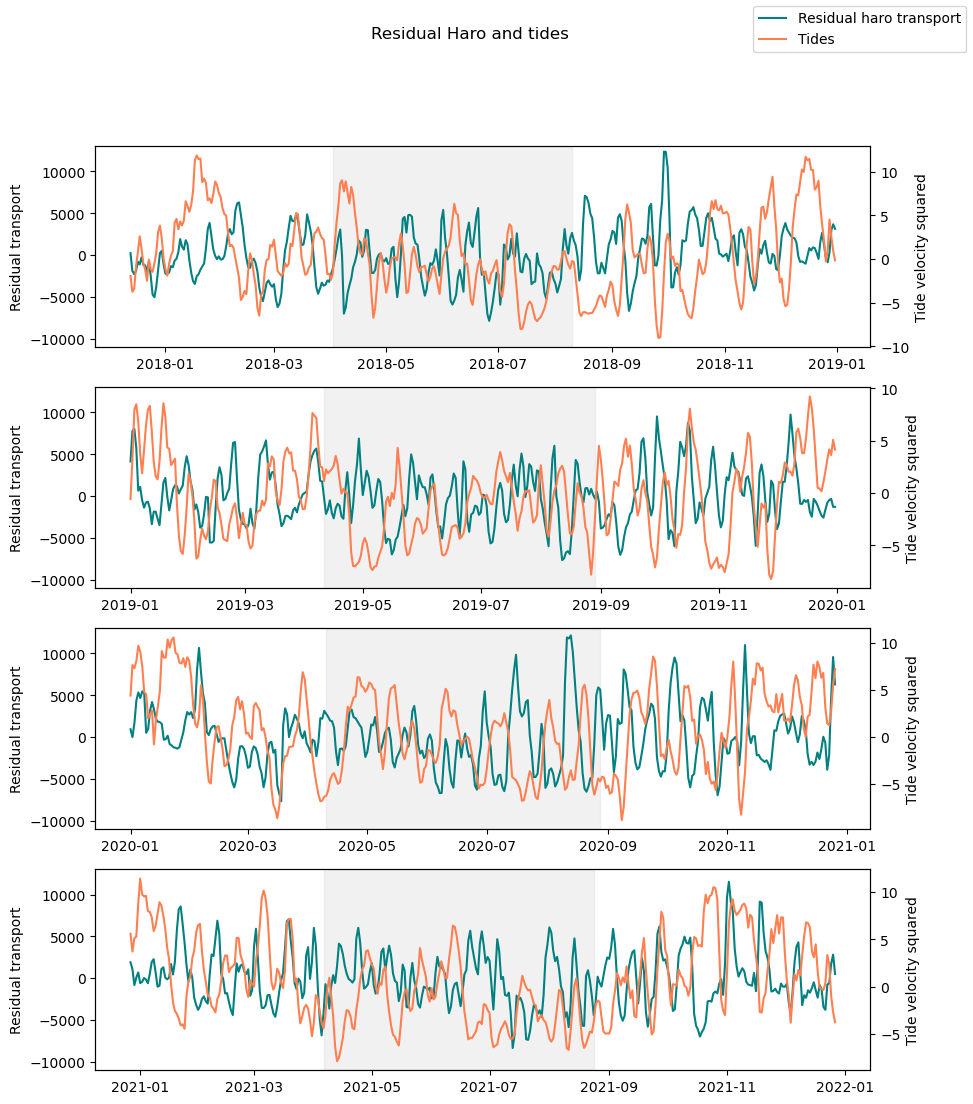

In [51]:
corr_2018,p = stats.spearmanr(winds_gulftovs_2018[110:240],res_Gulftovs_2018[110:240])
print(corr_2018)
corr_2019,p = stats.spearmanr(winds_gulftovs_2019[100:240],res_Gulftovs_2019[100:240])
print(corr_2019)
corr_2020,p = stats.spearmanr(winds_gulftovs_2020[100:240],res_Gulftovs_2020[100:240])
print(corr_2020)
corr_2021,p = stats.spearmanr(winds_gulftovs_2021[100:240],res_Gulftovs_2021[100:240])
print(corr_2021)

fig,[ax,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(10,12))
ax.plot(res_prtovs_2018,color='teal',label='Residual haro transport')
ax12 = ax.twinx()
ax12.plot(date_prtovs_2018,winds_gulftovs_2018,color='coral',label='Tides')
ax.set_ylim((-11000,13000))
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs_2018[110],x2=date_prtovs_2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Residual transport')
ax12.set_ylabel('Tide velocity squared')

ax2.plot(res_prtovs_2019,color='teal')
ax22 = ax2.twinx()
ax22.plot(date_prtovs_2019,winds_gulftovs_2019,color='coral')
ax2.set_ylim((-11000,13000))
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=date_prtovs_2019[100],x2=date_prtovs_2019[240],color='lightgrey', alpha=0.3)
ax2.set_ylabel('Residual transport')
ax22.set_ylabel('Tide velocity squared')

ax3.plot(res_prtovs_2020,color='teal')
ax32 = ax3.twinx()
ax32.plot(date_prtovs_2020,winds_gulftovs_2020,color='coral')
ax3.set_ylim((-11000,13000))
ax3.fill_betweenx(y=np.linspace(ax3.get_ylim()[0], ax3.get_ylim()[1], 100),x1=date_prtovs_2020[100],x2=date_prtovs_2020[240],color='lightgrey', alpha=0.3)
ax3.set_ylabel('Residual transport')
ax32.set_ylabel('Tide velocity squared')

ax4.plot(res_prtovs_2021,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtovs_2021,winds_gulftovs_2021,color='coral')
ax4.set_ylim((-11000,13000))
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_prtovs_2021[100],x2=date_prtovs_2021[240],color='lightgrey', alpha=0.3)
ax4.set_ylabel('Residual transport')
ax42.set_ylabel('Tide velocity squared')

fig.suptitle('Residual Haro and tides')
fig.legend()